# **DIVE INTO CODE COURSE**
## **TensorFlow**
**Student Name**: Doan Anh Tien<br>
**Student ID**: 1852789<br>
**Email**: tien.doan.g0pr0@hcmut.edu.vn

### **[Problem 1] Looking back on the scratch**

Tasks that should be conducted for implementing machine learning model:


*   Preparing dataset
*   Pre-processing dataset
*   Split train and test set
*   Initialize hyperparameters
*   Initialize weight and bias
*   Create model class/functions
*   Define objective function, optimizer and evaluation metrics
*   Start session for dataflow





### **[Problem 2] Consider the correspondence between scratch and TensorFlow**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')

tf.test.gpu_device_name() 
# tf.disable_eager_execution()

'/device:GPU:0'

In [18]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [14]:
df = pd.read_csv("sample_data/Iris.csv")
#Condition extraction from data frame
df = df[(df["Species"] == "Iris-versicolor") | (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)
# Convert label to number
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [15]:
# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    Simple 3-layer neural network
    """
    tf.random.set_random_seed(0)
    # Declaration of weight and bias
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.add and + are equivalent
    return layer_output
#Read network structure                              
logits = example_net(X)
# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Estimated result
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#Initialization of variable
init = tf.global_variables_initializer()

#Run calculation graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 7.0241, val_loss : 67.6860, acc : 0.375
Epoch 1, loss : 3.4241, val_loss : 23.4026, acc : 0.312
Epoch 2, loss : 1.9387, val_loss : 11.6681, acc : 0.375
Epoch 3, loss : 2.0917, val_loss : 13.1400, acc : 0.312
Epoch 4, loss : 1.7685, val_loss : 17.7283, acc : 0.312
Epoch 5, loss : 1.6097, val_loss : 12.9607, acc : 0.312
Epoch 6, loss : 1.4402, val_loss : 10.0593, acc : 0.312
Epoch 7, loss : 1.3704, val_loss : 9.4797, acc : 0.312
Epoch 8, loss : 1.2536, val_loss : 9.8518, acc : 0.312
Epoch 9, loss : 1.1476, val_loss : 8.5670, acc : 0.375
Epoch 10, loss : 1.0930, val_loss : 8.0429, acc : 0.375
Epoch 11, loss : 1.0412, val_loss : 7.8791, acc : 0.375
Epoch 12, loss : 0.9804, val_loss : 7.1233, acc : 0.375
Epoch 13, loss : 0.9326, val_loss : 6.7908, acc : 0.375
Epoch 14, loss : 0.8792, val_loss : 6.2492, acc : 0.375
Epoch 15, loss : 0.8304, val_loss : 5.7681, acc : 0.375
Epoch 16, loss : 0.7835, val_loss : 5.2886, acc : 0.438
Epoch 17, loss : 0.7384, val_loss : 4.8037, acc : 0

### **[Problem 3] Create a model of Iris using all three types of objective variables**

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

tf.test.gpu_device_name() 
# tf.disable_eager_execution()

'/device:GPU:0'

In [23]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [24]:
df = pd.read_csv("sample_data/Iris.csv")
#Condition extraction from data frame
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# Convert label to number
y[y == "Iris-setosa"] = 0
y[y == "Iris-versicolor"] = 1
y[y == "Iris-virginica"] = 2
# One Hot encoder
y = np_utils.to_categorical(y)
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [25]:
# Standardizing
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [32]:
# Hyperparameter settings
learning_rate = 0.01
batch_size = 10
num_epochs = 50
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
class IrisModel(tf.keras.Model):
    """
    Simple 3-layer multi-classification neural network
    """
    def __init__(self):
      super().__init__()
      # Declaration of weight
      self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
      self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
      self.w3 =  tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
      # Declaration of bias
      self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
      self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
      self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
      
    def call(self, x):
      """
      Fit the train dataset into the model's dataflow
      """
      layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
      layer_1 = tf.nn.relu(layer_1)
      layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
      layer_2 = tf.nn.relu(layer_2)
      layer_output = tf.matmul(layer_2, self.w3) + self.b3

      return layer_output

#Read network structure                              
model = IrisModel()
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Train function
def train(x, y):
  # Fit the train dataset into the model
  logits = model(x, training=True)
  # Objective function
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))

  return loss

def evaluate(x, y):
  # Fit the validation dataset into the model
  logits = model(x)
  # Objective function
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
  # Estimated result
  correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
  #Indicator value calculation
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  return loss, accuracy

train_loss_list = list()
val_loss_list = list()
acc_list = list()

#Run calculation graph
for epoch in range(num_epochs):
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
                         
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss

    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)

    # History record
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    acc_list.append(val_acc)

    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
    
_, test_acc = evaluate(X_test, y_test)
print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.5072, val_loss : 1.1401, val_acc : 0.833
Epoch 1, loss : 0.0818, val_loss : 0.4293, val_acc : 0.875
Epoch 2, loss : 0.0008, val_loss : 0.4654, val_acc : 0.917
Epoch 3, loss : 0.0097, val_loss : 0.8173, val_acc : 0.958
Epoch 4, loss : 0.0090, val_loss : 0.7985, val_acc : 0.917
Epoch 5, loss : 0.0078, val_loss : 0.7792, val_acc : 0.917
Epoch 6, loss : 0.0042, val_loss : 0.8297, val_acc : 0.958
Epoch 7, loss : 0.0024, val_loss : 1.0961, val_acc : 0.917
Epoch 8, loss : 0.0072, val_loss : 0.8319, val_acc : 0.958
Epoch 9, loss : 0.0001, val_loss : 0.5759, val_acc : 0.917
Epoch 10, loss : 0.0015, val_loss : 1.2093, val_acc : 0.917
Epoch 11, loss : 0.0077, val_loss : 0.9633, val_acc : 0.958
Epoch 12, loss : 0.0004, val_loss : 0.7557, val_acc : 0.958
Epoch 13, loss : 0.0001, val_loss : 0.7801, val_acc : 0.958
Epoch 14, loss : 0.0000, val_loss : 0.8053, val_acc : 0.958
Epoch 15, loss : 0.0000, val_loss : 0.8174, val_acc : 0.958
Epoch 16, loss : 0.0000, val_loss : 0.8233, val_ac

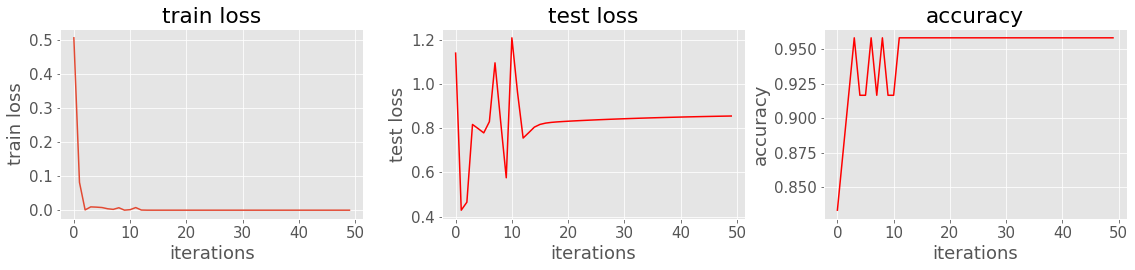

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1, 3, 1)   
ax1.plot(train_loss_list)
ax1.set_title('train loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('train loss')


ax2 = fig.add_subplot(1, 3, 2)  
ax2.plot(val_loss_list, color='red')
ax2.set_title('test loss')
ax2.set_xlabel('iterations')
ax2.set_ylabel('test loss')

ax3 = fig.add_subplot(1, 3, 3)  
ax3.plot(acc_list, color='red')
ax3.set_title('accuracy')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accuracy')

plt.tight_layout()
plt.show()

### **[Problem 4] Creating a model of House Prices**

Since this is an regression problem, we do not actually need to measure the accuracy

In [34]:
df = pd.read_csv("sample_data/train.csv")
#Condition extraction from data frame
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.log(np.array(y).reshape(-1, 1))
X = np.array(X).astype(np.float32)
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [39]:
# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 50
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class HousingModel(tf.keras.Model):
    """
    Simple 3-layer multi-classification neural network
    """
    def __init__(self):
      super().__init__()
      # Declaration of weight
      self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
      self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
      self.w3 =  tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
      # Declaration of bias
      self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
      self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
      self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
      
    def call(self, x):
      """
      Fit the train dataset into the model's dataflow
      """
      layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
      layer_1 = tf.nn.relu(layer_1)
      layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
      layer_2 = tf.nn.relu(layer_2)
      layer_output = tf.matmul(layer_2, self.w3) + self.b3

      return layer_output


#Read network structure                              
model = HousingModel()
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Train function
def train(x, y):
  # Fit the train dataset into the model
  logits = model(x, training=True)
  # Objective function
  loss = tf.reduce_mean(tf.losses.mean_squared_error(y, logits))

  return loss

def evaluate(x, y):
  # Fit the validation dataset into the model
  logits = model(x)
  # Objective function
  loss = tf.reduce_mean(tf.losses.mean_squared_error(y, logits))

  return loss

train_loss_list = list()
val_loss_list = list()

#Run calculation graph
for epoch in range(num_epochs):
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
                         
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    loss = evaluate(X_train, y_train)
    train_loss_list.append(loss)
    val_loss = evaluate(X_val, y_val)
    val_loss_list.append(val_loss)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    
test_loss = evaluate(X_test, y_test)
print("test_loss : {:.3f}".format(test_loss))

Epoch 0, loss : 10313022.0000, val_loss : 5575881.0000
Epoch 1, loss : 3837397.5000, val_loss : 1443196.1250
Epoch 2, loss : 1615059.5000, val_loss : 360551.1250
Epoch 3, loss : 733681.9375, val_loss : 103096.0156
Epoch 4, loss : 393912.7812, val_loss : 55785.6562
Epoch 5, loss : 237253.0938, val_loss : 48794.1680
Epoch 6, loss : 160417.1406, val_loss : 51554.6172
Epoch 7, loss : 128755.5625, val_loss : 52194.3320
Epoch 8, loss : 109381.9609, val_loss : 53912.6328
Epoch 9, loss : 94740.6250, val_loss : 52887.0820
Epoch 10, loss : 82432.7734, val_loss : 50018.0273
Epoch 11, loss : 71533.6562, val_loss : 45933.8750
Epoch 12, loss : 61966.4727, val_loss : 41677.6523
Epoch 13, loss : 54229.4414, val_loss : 37587.4023
Epoch 14, loss : 47837.1250, val_loss : 33692.5000
Epoch 15, loss : 42036.7148, val_loss : 29965.9863
Epoch 16, loss : 37592.3945, val_loss : 26374.4590
Epoch 17, loss : 34540.3555, val_loss : 23088.4258
Epoch 18, loss : 31449.1426, val_loss : 20330.9375
Epoch 19, loss : 28908

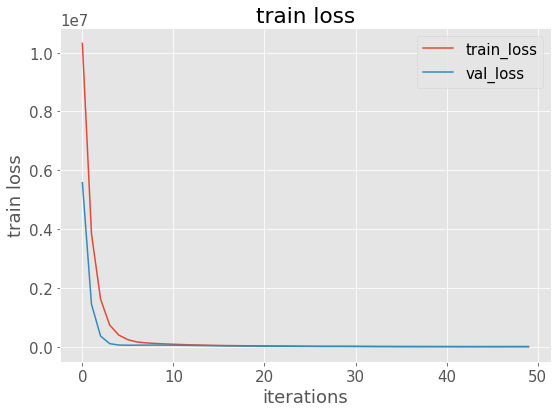

In [42]:
plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(1, 1, 1)   
ax1.plot(train_loss_list, label='train_loss')
ax1.plot(val_loss_list, label='val_loss')
ax1.set_title('train loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('train loss')

plt.legend()
plt.tight_layout()
plt.show()

### **[Problem 5] Creating a MNIST model**

In [43]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [44]:
print(X_train.shape) # (60000, 28, 28)
print(y_train.shape) # (10000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_test.shape)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8


**Visualization**

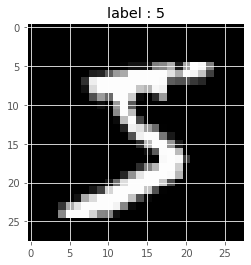

In [45]:
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

**Preprocessing**

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [47]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train = X_train / 255.0
X_test = X_test / 255.0

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(48000, 784)
(10000, 784)


In [51]:
# Hyperparameter settings
learning_rate = 0.01
batch_size = 20
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MNISTModel(tf.keras.Model):
    """
    Simple 3-layer multi-classification neural network
    """
    def __init__(self):
      super().__init__()
      # Declaration of weight
      self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
      self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
      self.w3 =  tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
      # Declaration of bias
      self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
      self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
      self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
      
    def call(self, x):
      """
      Fit the train dataset into the model's dataflow
      """
      layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
      layer_1 = tf.nn.relu(layer_1)
      layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
      layer_2 = tf.nn.relu(layer_2)
      layer_output = tf.matmul(layer_2, self.w3) + self.b3

      return layer_output


#Read network structure                              
model = MNISTModel()
optimizer = tf.optimizers.Adagrad(learning_rate=learning_rate)

# Train function
def train(x, y):
  # Fit the train dataset into the model
  logits = model(x, training=True)
  # Objective function
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))

  return loss

def evaluate(x, y):
  # Fit the validation dataset into the model
  logits = model(x)
  # Objective function
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, logits))
  # Estimated result
  correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
  # Indicator value calculation
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  return loss, accuracy

train_loss_list = list()
val_loss_list = list()
val_acc_list = list()

#Run calculation graph
for epoch in range(num_epochs):
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
                         
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss

    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)

    # History record
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
    
_, test_acc = evaluate(X_test, y_test_one_hot)
print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 22.9094, val_loss : 19.1745, val_acc : 0.665
Epoch 1, loss : 23.7258, val_loss : 14.5815, val_acc : 0.703
Epoch 2, loss : 24.3778, val_loss : 12.4521, val_acc : 0.718
Epoch 3, loss : 24.9394, val_loss : 11.1405, val_acc : 0.731
Epoch 4, loss : 25.4406, val_loss : 10.2278, val_acc : 0.740
Epoch 5, loss : 25.8984, val_loss : 9.5185, val_acc : 0.746
Epoch 6, loss : 26.3223, val_loss : 8.9441, val_acc : 0.748
Epoch 7, loss : 26.7192, val_loss : 8.4764, val_acc : 0.753
Epoch 8, loss : 27.0937, val_loss : 8.0810, val_acc : 0.757
Epoch 9, loss : 27.4492, val_loss : 7.7366, val_acc : 0.759
Epoch 10, loss : 27.7883, val_loss : 7.4325, val_acc : 0.762
Epoch 11, loss : 28.1130, val_loss : 7.1698, val_acc : 0.765
Epoch 12, loss : 28.4252, val_loss : 6.9402, val_acc : 0.767
Epoch 13, loss : 28.7261, val_loss : 6.7318, val_acc : 0.770
Epoch 14, loss : 29.0166, val_loss : 6.5412, val_acc : 0.771
Epoch 15, loss : 29.2977, val_loss : 6.3659, val_acc : 0.773
Epoch 16, loss : 29.5701, val

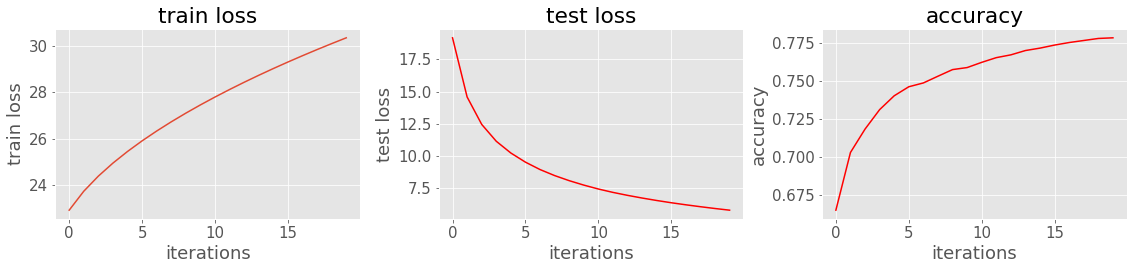

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1, 3, 1)   
ax1.plot(train_loss_list)
ax1.set_title('train loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('train loss')


ax2 = fig.add_subplot(1, 3, 2)  
ax2.plot(val_loss_list, color='red')
ax2.set_title('test loss')
ax2.set_xlabel('iterations')
ax2.set_ylabel('test loss')

ax3 = fig.add_subplot(1, 3, 3)  
ax3.plot(val_acc_list, color='red')
ax3.set_title('accuracy')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accuracy')

plt.tight_layout()
plt.show()